In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install missingno

In [3]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.7 MB/s eta 0:00:00


In [4]:
pip install pystan==2.19.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 84.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystan: filename=pystan-2.19.1.1-cp310-cp310-linux_x86_64.whl size=61973723 sha256=3615c766963c1ca6d89f4e276f391be396807d8765a61924221d565ea11eaffd
  Stored in directory: /root/.cache/pip/wheels/3d/1c/94/4516243362eedbedad15ac4389691ee3bf2d45bec2639c9d8b
Successfully built pystan


In [5]:
!pip install prophet


In [6]:
# Magic function that makes plot outputs appear within the notebook
%matplotlib inline

# Function used to render higher resolution images
%config InlineBackend.figure_format = 'retina'

# Ignore all warnings to keep the output clean
import warnings
warnings.filterwarnings("ignore")

# For reproducibility, you can set a random seed
import random

# Data manipulation
import os
import pandas as pd
import numpy as np
from datetime import datetime, date

# Display all columns and prevent frame expansion in DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Data visualization setup
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Set the Seaborn theme and color palette for visualizations
sns.set_theme()
sns.set_palette("pastel")
plt.style.use('seaborn-whitegrid')

# Machine learning models and evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import pmdarima as pm
from prophet import Prophet
import math
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller



In [59]:
# Reading dataset .csv file
df=pd.read_csv("/content/drive/MyDrive/MY ML Work/DailyDelhiClimateTrain.csv")

In [60]:
# Dataset sneak peek
df.head(3)

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.5,0.000000,1015.666667
1,2013-01-02,7.400000,92.0,2.980000,1017.800000
2,2013-01-03,7.166667,87.0,4.633333,1018.666667


In [61]:
df.tail(3)

,date,meantemp,humidity,wind_speed,meanpressure
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000
1461,2017-01-01,10.000000,100.000000,0.000000,1016.000000


In [62]:
df.shape


(1462, 5)

In [72]:
# Dataset length
print('The total number of  dataset is: ',len(df))

The total number of  dataset is:  1462


In [64]:
# Date original data type
type(df['date'][0])

str

In [65]:
# Transforming date(str) to Timestamp format
df['date'] =pd.to_datetime(df['date'], format = '%Y/%m/%d')
type(df['date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [74]:
# Table showing the number of missing values and percentage
# of missing values in the current dataset
dict = {}
for i in list(df.columns):
    dict[i] = (df[i].isnull().sum(),round(df[i].isnull().sum()/len(df)*100,2))

pd.DataFrame(dict,index=["#  missing values","% of missing values"]).transpose().sort_values(by=["#  missing values"], ascending=False)

,# missing values,% of missing values
date,0.0,0.0
meantemp,0.0,0.0
humidity,0.0,0.0
wind_speed,0.0,0.0
meanpressure,0.0,0.0


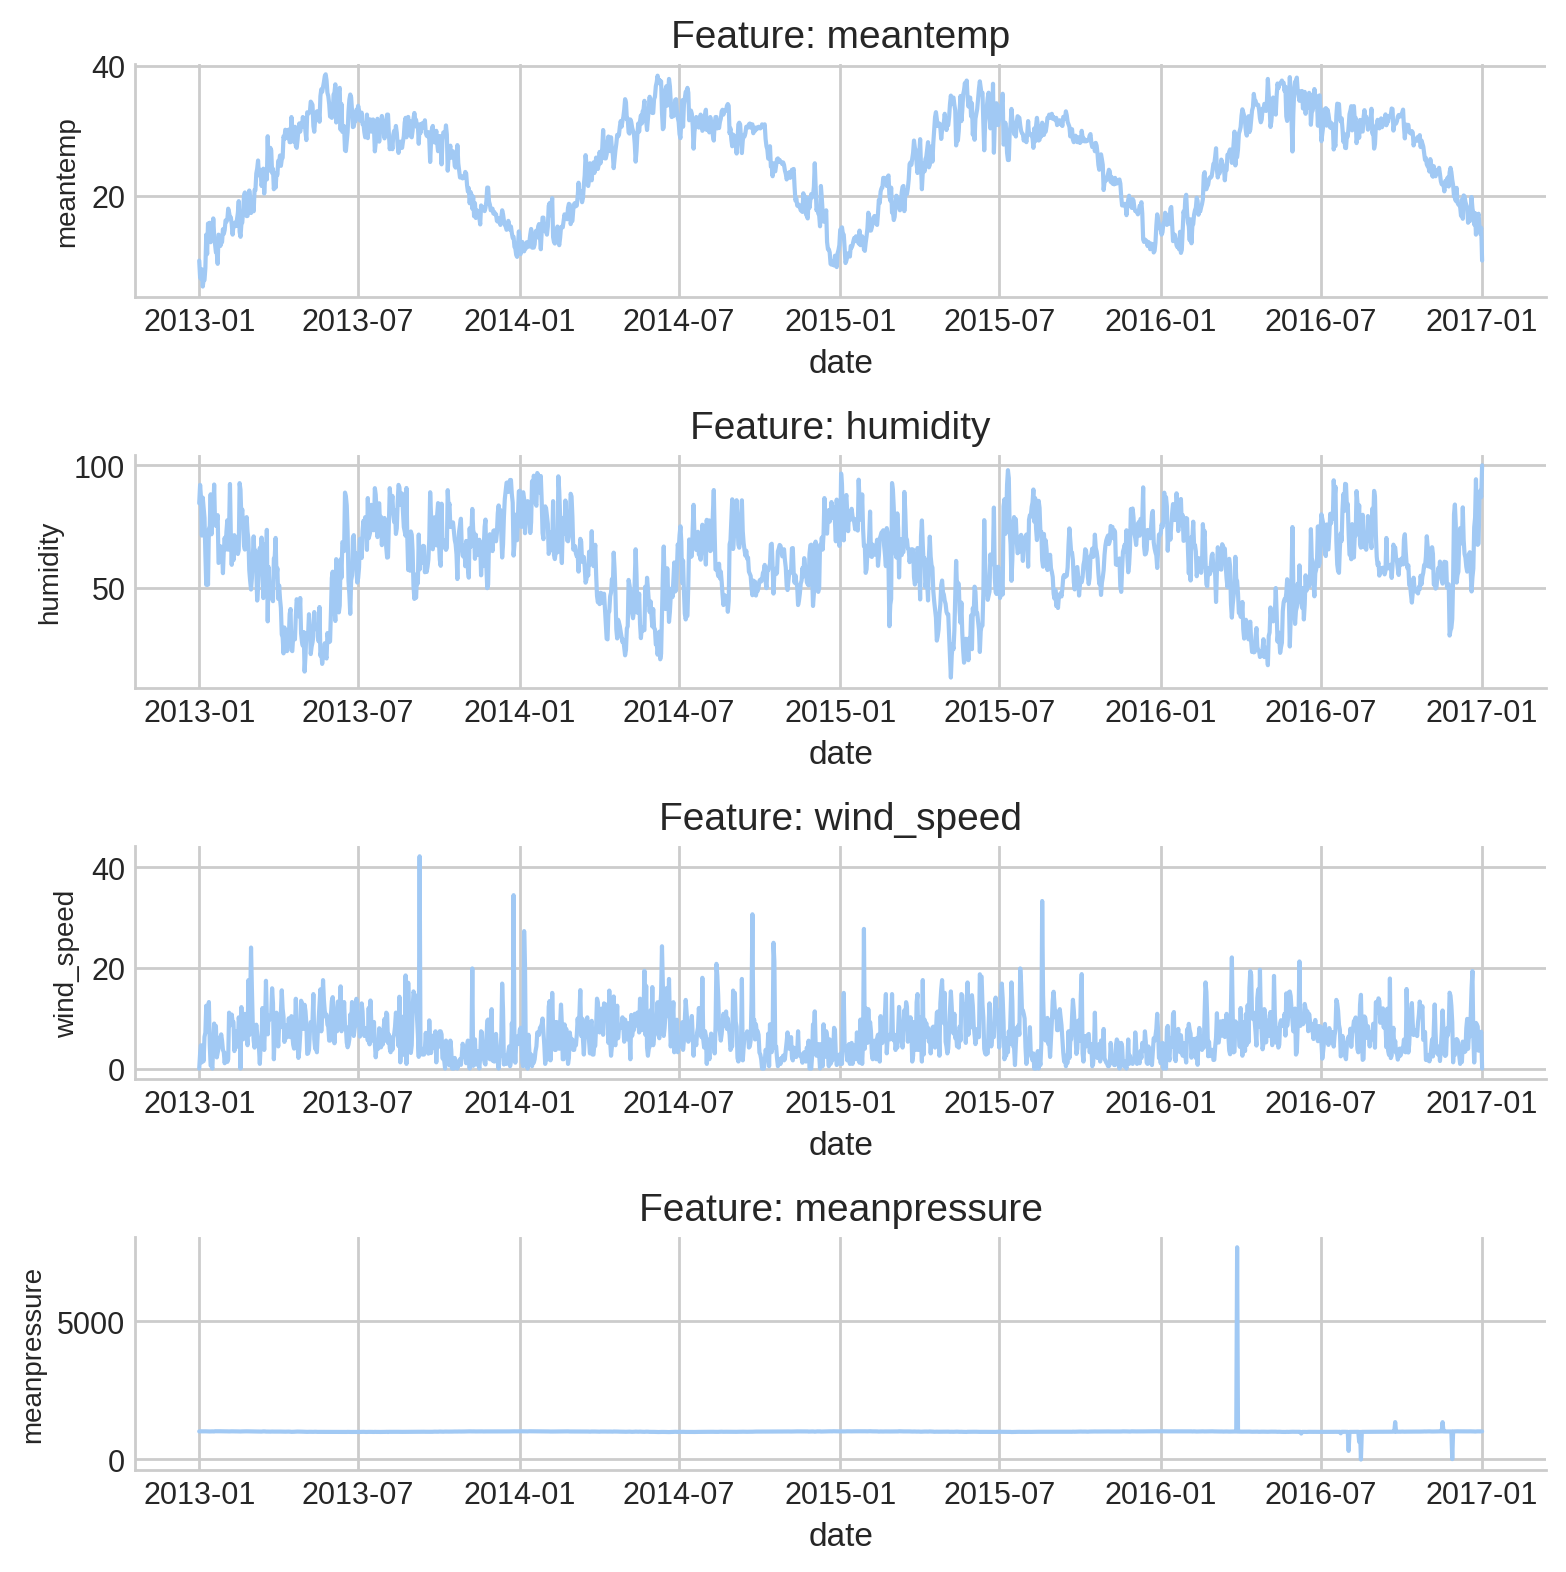

In [67]:
# Plotting each of the time series
fig, ax =plt.subplots(nrows=4,ncols=1,figsize=(8,8))
sns.despine()

for i, column in enumerate(df.drop('date', axis=1).columns):
    sns.lineplot(x=df['date'], y=df[column], ax=ax[i])
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=10)

plt.tight_layout()

In [15]:
# Function for outlier removal
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [16]:
# Applying remove_outlier fuction to meanpressure feature
mean_pre= remove_outlier(df, 'meanpressure')

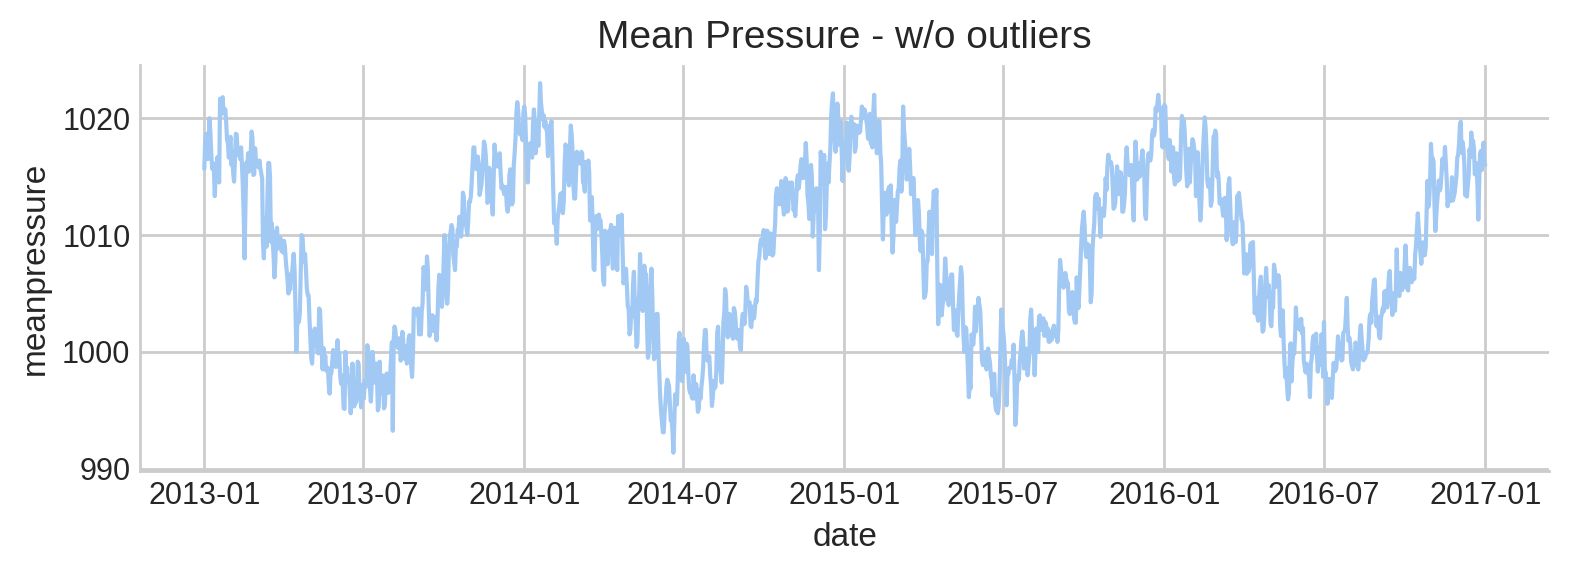

In [17]:
# Plotting meaenpressure w/o outliers for a better visualization
fig, ax =plt.subplots(figsize=(8,3))
sns.despine()
ax.set_title('Mean Pressure - w/o outliers', size=14)
sns.lineplot(data=mean_pre,x='date',y='meanpressure')

plt.tight_layout()

In [18]:
# Replacing outliers with NaN values
def replace_outliers(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range

    df_in.loc[(df[col_name]<q1-1.5*iqr) | (df[col_name]>q3 + 1.5*iqr),col_name] = np.nan

    return df_in

In [19]:
# Applying replace_outliers function to meanpressure
df = replace_outliers(df,'meanpressure' )

In [20]:
# Quantifying how many NaN value we have after replace_outliers was applied
print('Total NaN values for meanpressure',df['meanpressure'].isnull().sum())

Total NaN values for meanpressure 9


In [21]:
# Interpolating meanpressure NaN values
df['meanpressure'] = df['meanpressure'].interpolate()

In [22]:
# meanpressure NaN values after interpolation
print('Total NaN values for meanpressure',df['meanpressure'].isnull().sum())

Total NaN values for meanpressure 0


In [23]:
# Downsampling dataset Days -> Week
downsample = df[['date',
                 'meantemp',
                 'humidity',
                 'wind_speed',
                 'meanpressure'
                ]].resample('7D', on='date').mean().reset_index(drop=False)

df = downsample.copy()

In [24]:
# Number of rows of the dataset adter downsampling
print('The total number of rows dataset after downsampling: ',len(df))

The total number of rows dataset after downsampling:  209


In [70]:
# Function to visualize Augmented Dickey–Fuller test
def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen'
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'black'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

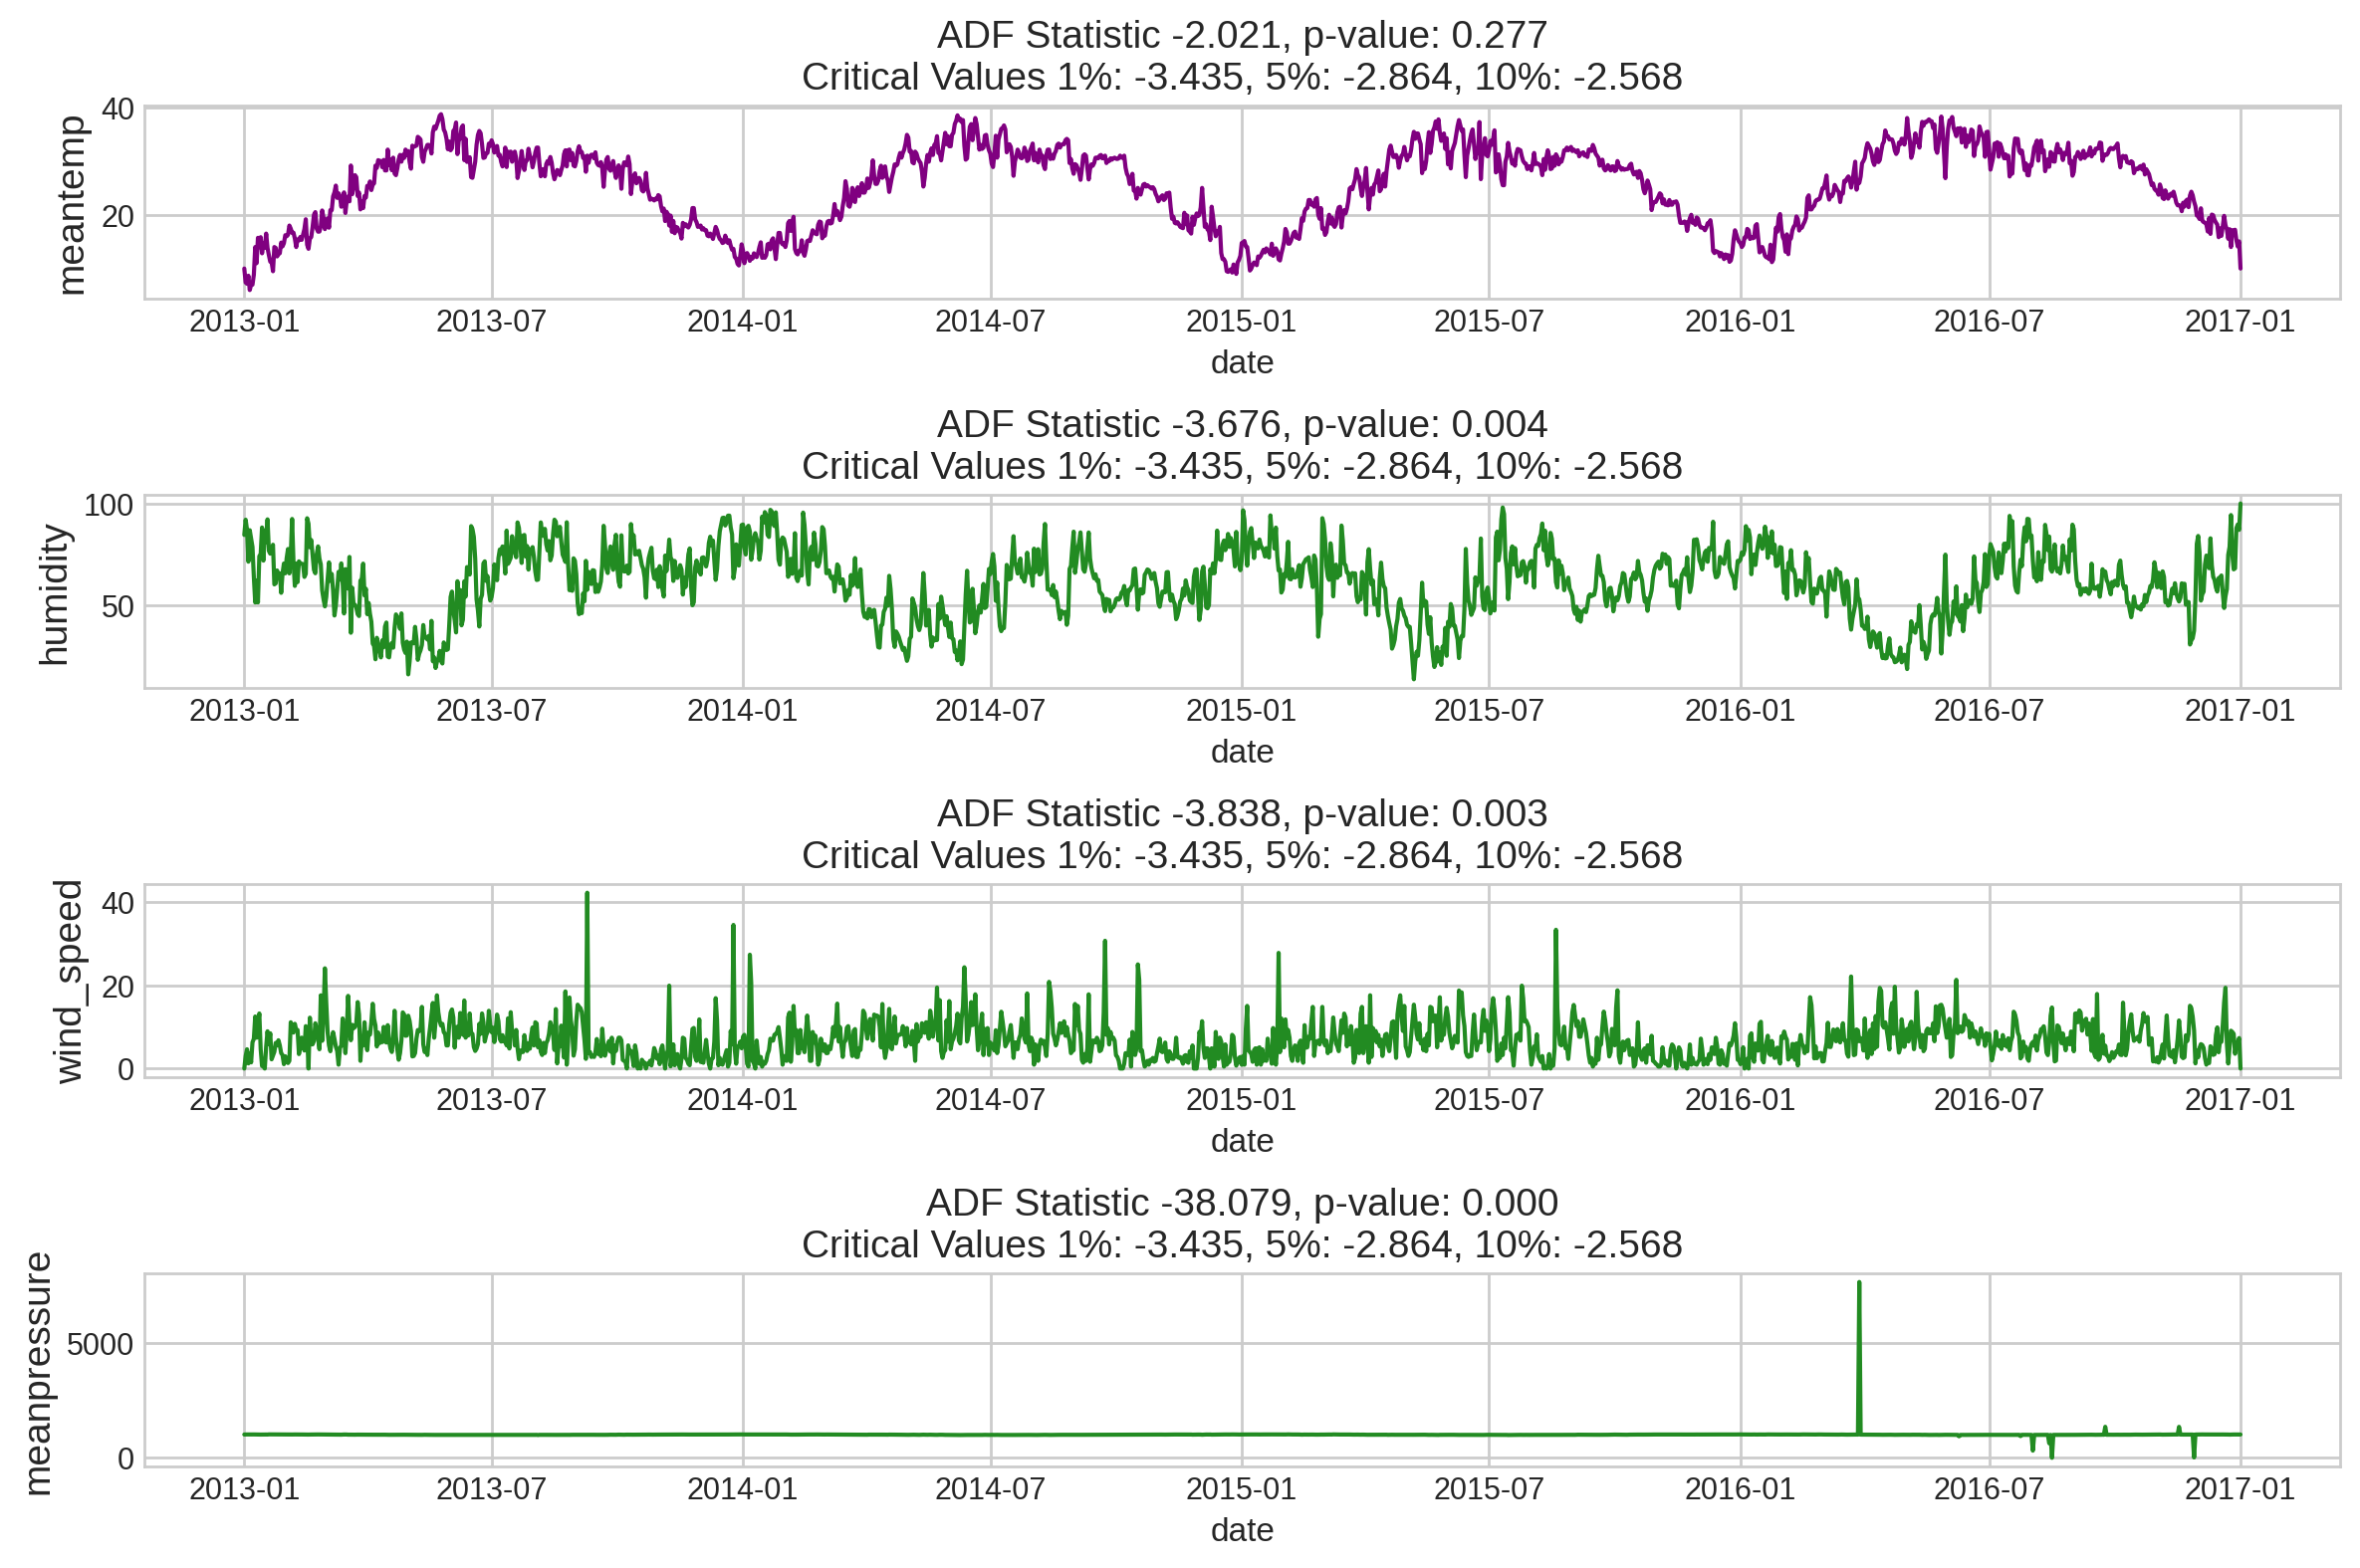

In [71]:
# Plotting Augmented Dickey–Fuller test results for each column
fig, ax =plt.subplots(nrows=4,ncols=1,figsize=(12,8))

visualize_adfuller_results(df['meantemp'].values, 'meantemp', ax[0])
visualize_adfuller_results(df['humidity'].values, 'humidity', ax[1])
visualize_adfuller_results(df['wind_speed'].values, 'wind_speed', ax[2])
visualize_adfuller_results(df['meanpressure'].values, 'meanpressure', ax[3])

plt.tight_layout()

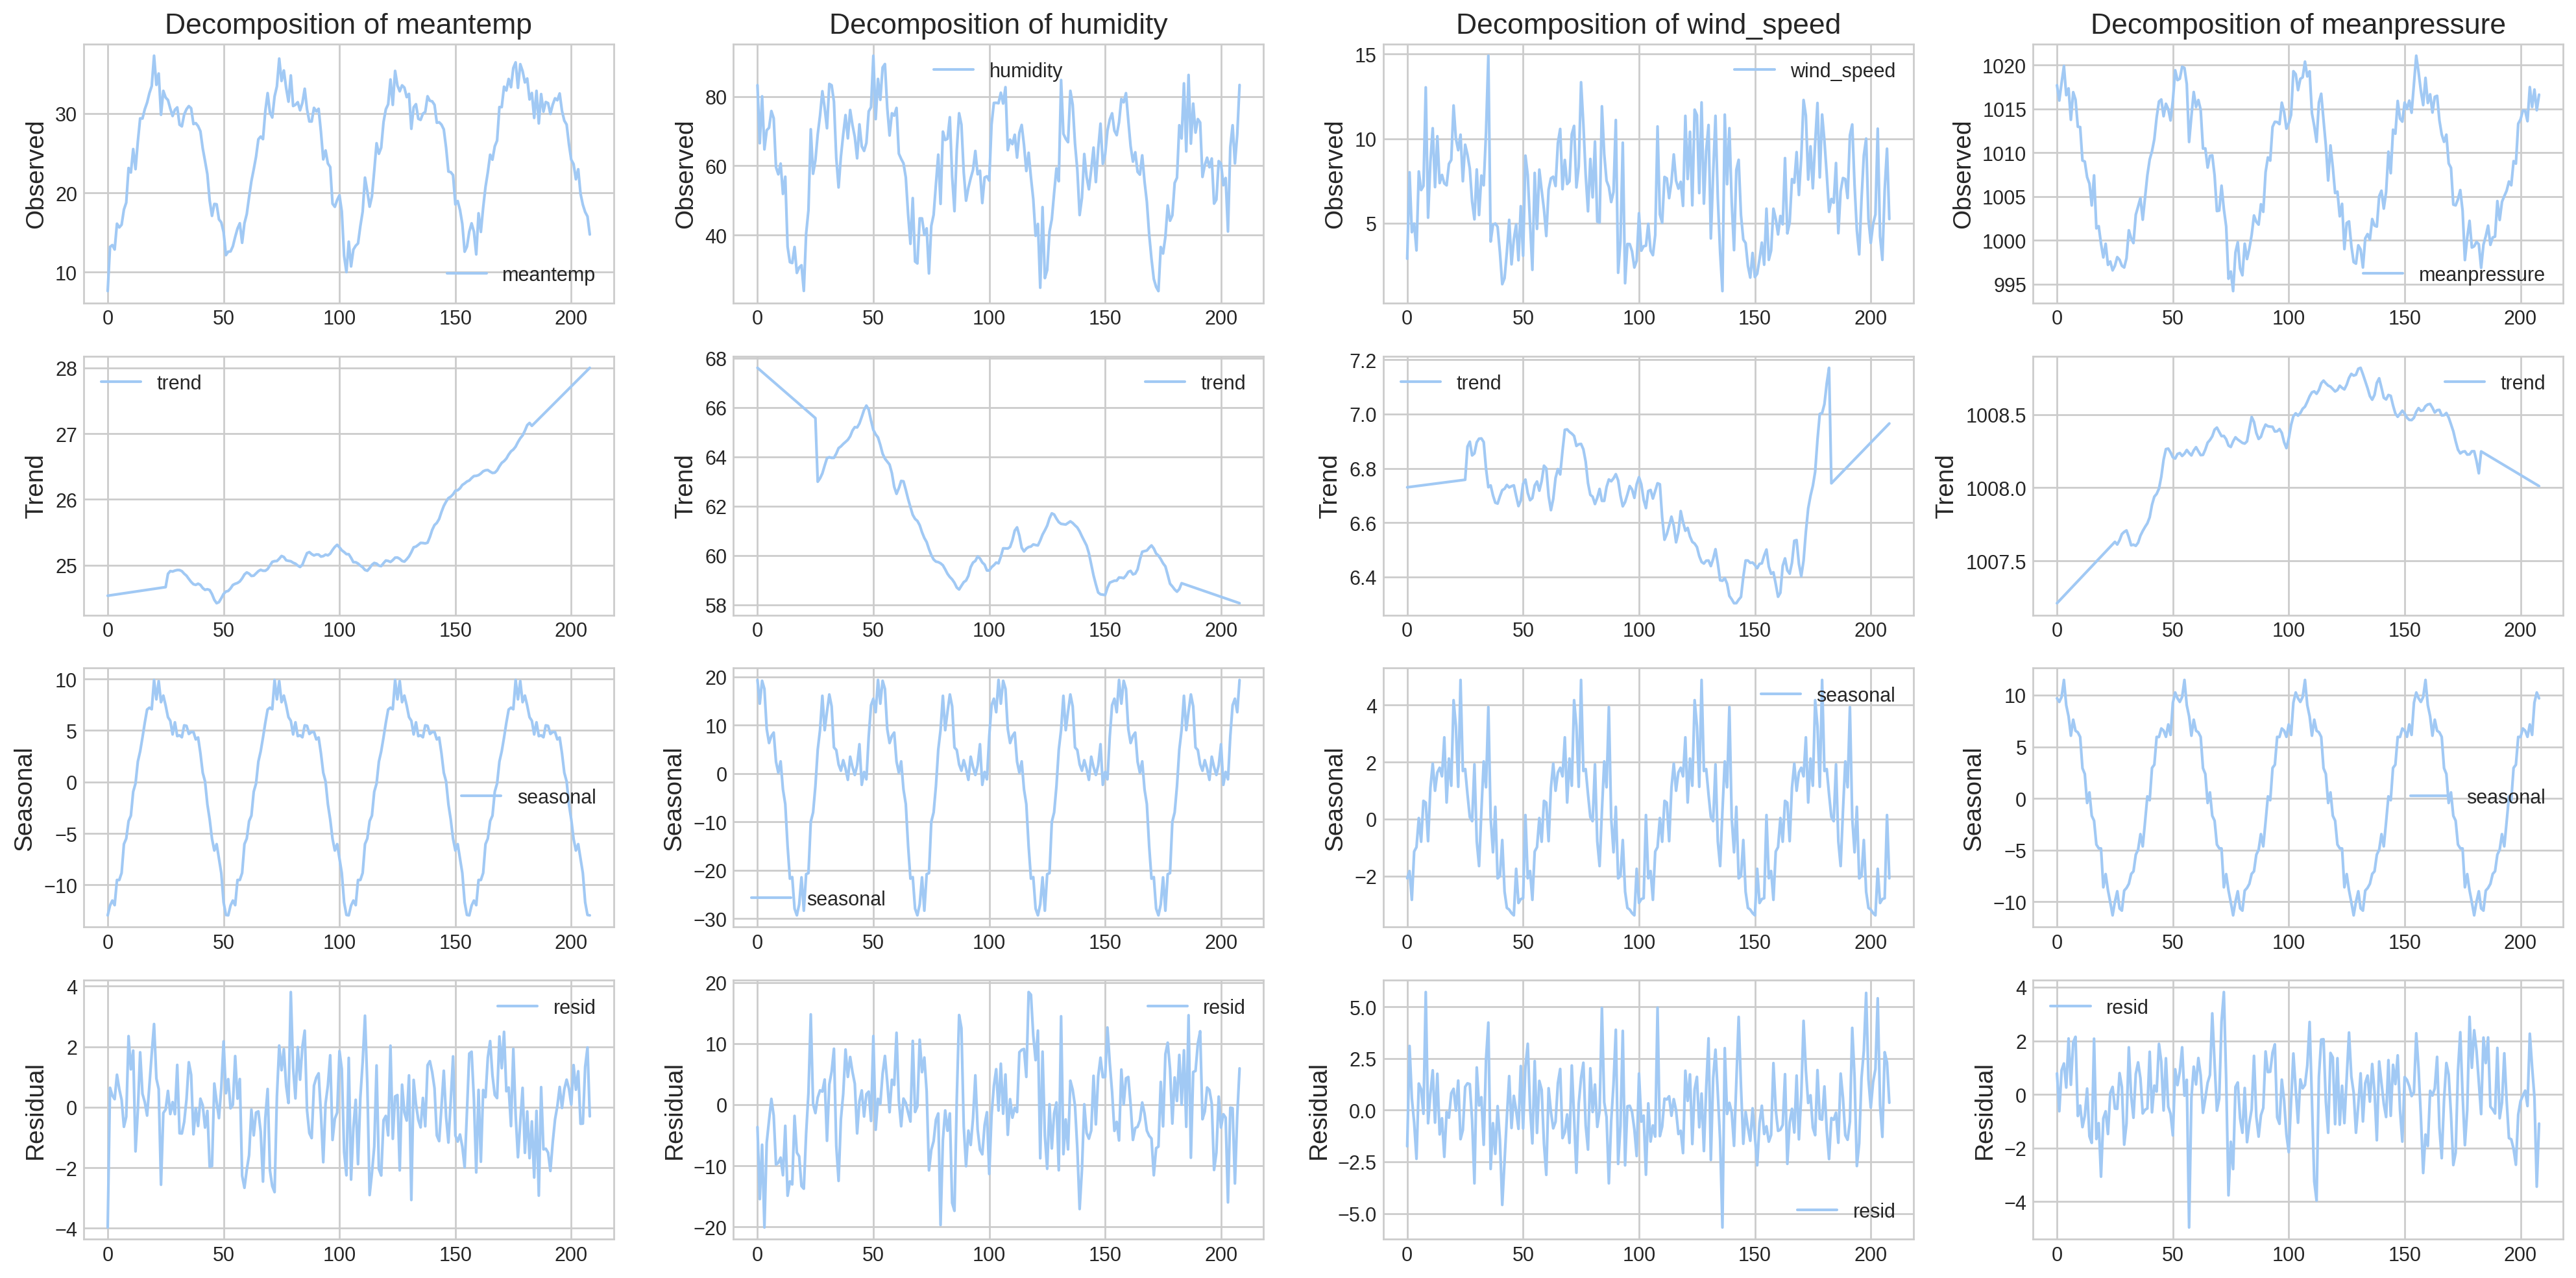

In [29]:
# Decomposing time series
columns=['meantemp','humidity','wind_speed','meanpressure']

fig, ax =plt.subplots(nrows=4,ncols=4,figsize=(20,10))

for i, column in enumerate(columns):

    res = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=True)
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=True)
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=True)
    ax[2,i].set_ylabel('Seasonal', fontsize=14)

    res.resid.plot(ax=ax[3,i], legend=True)
    ax[3,i].set_ylabel('Residual', fontsize=14)

plt.tight_layout()

We can observe that the trends show very little variation across all features, while seasonality is prominent in all features.

Let's take a closer look at the seasonality of each column.

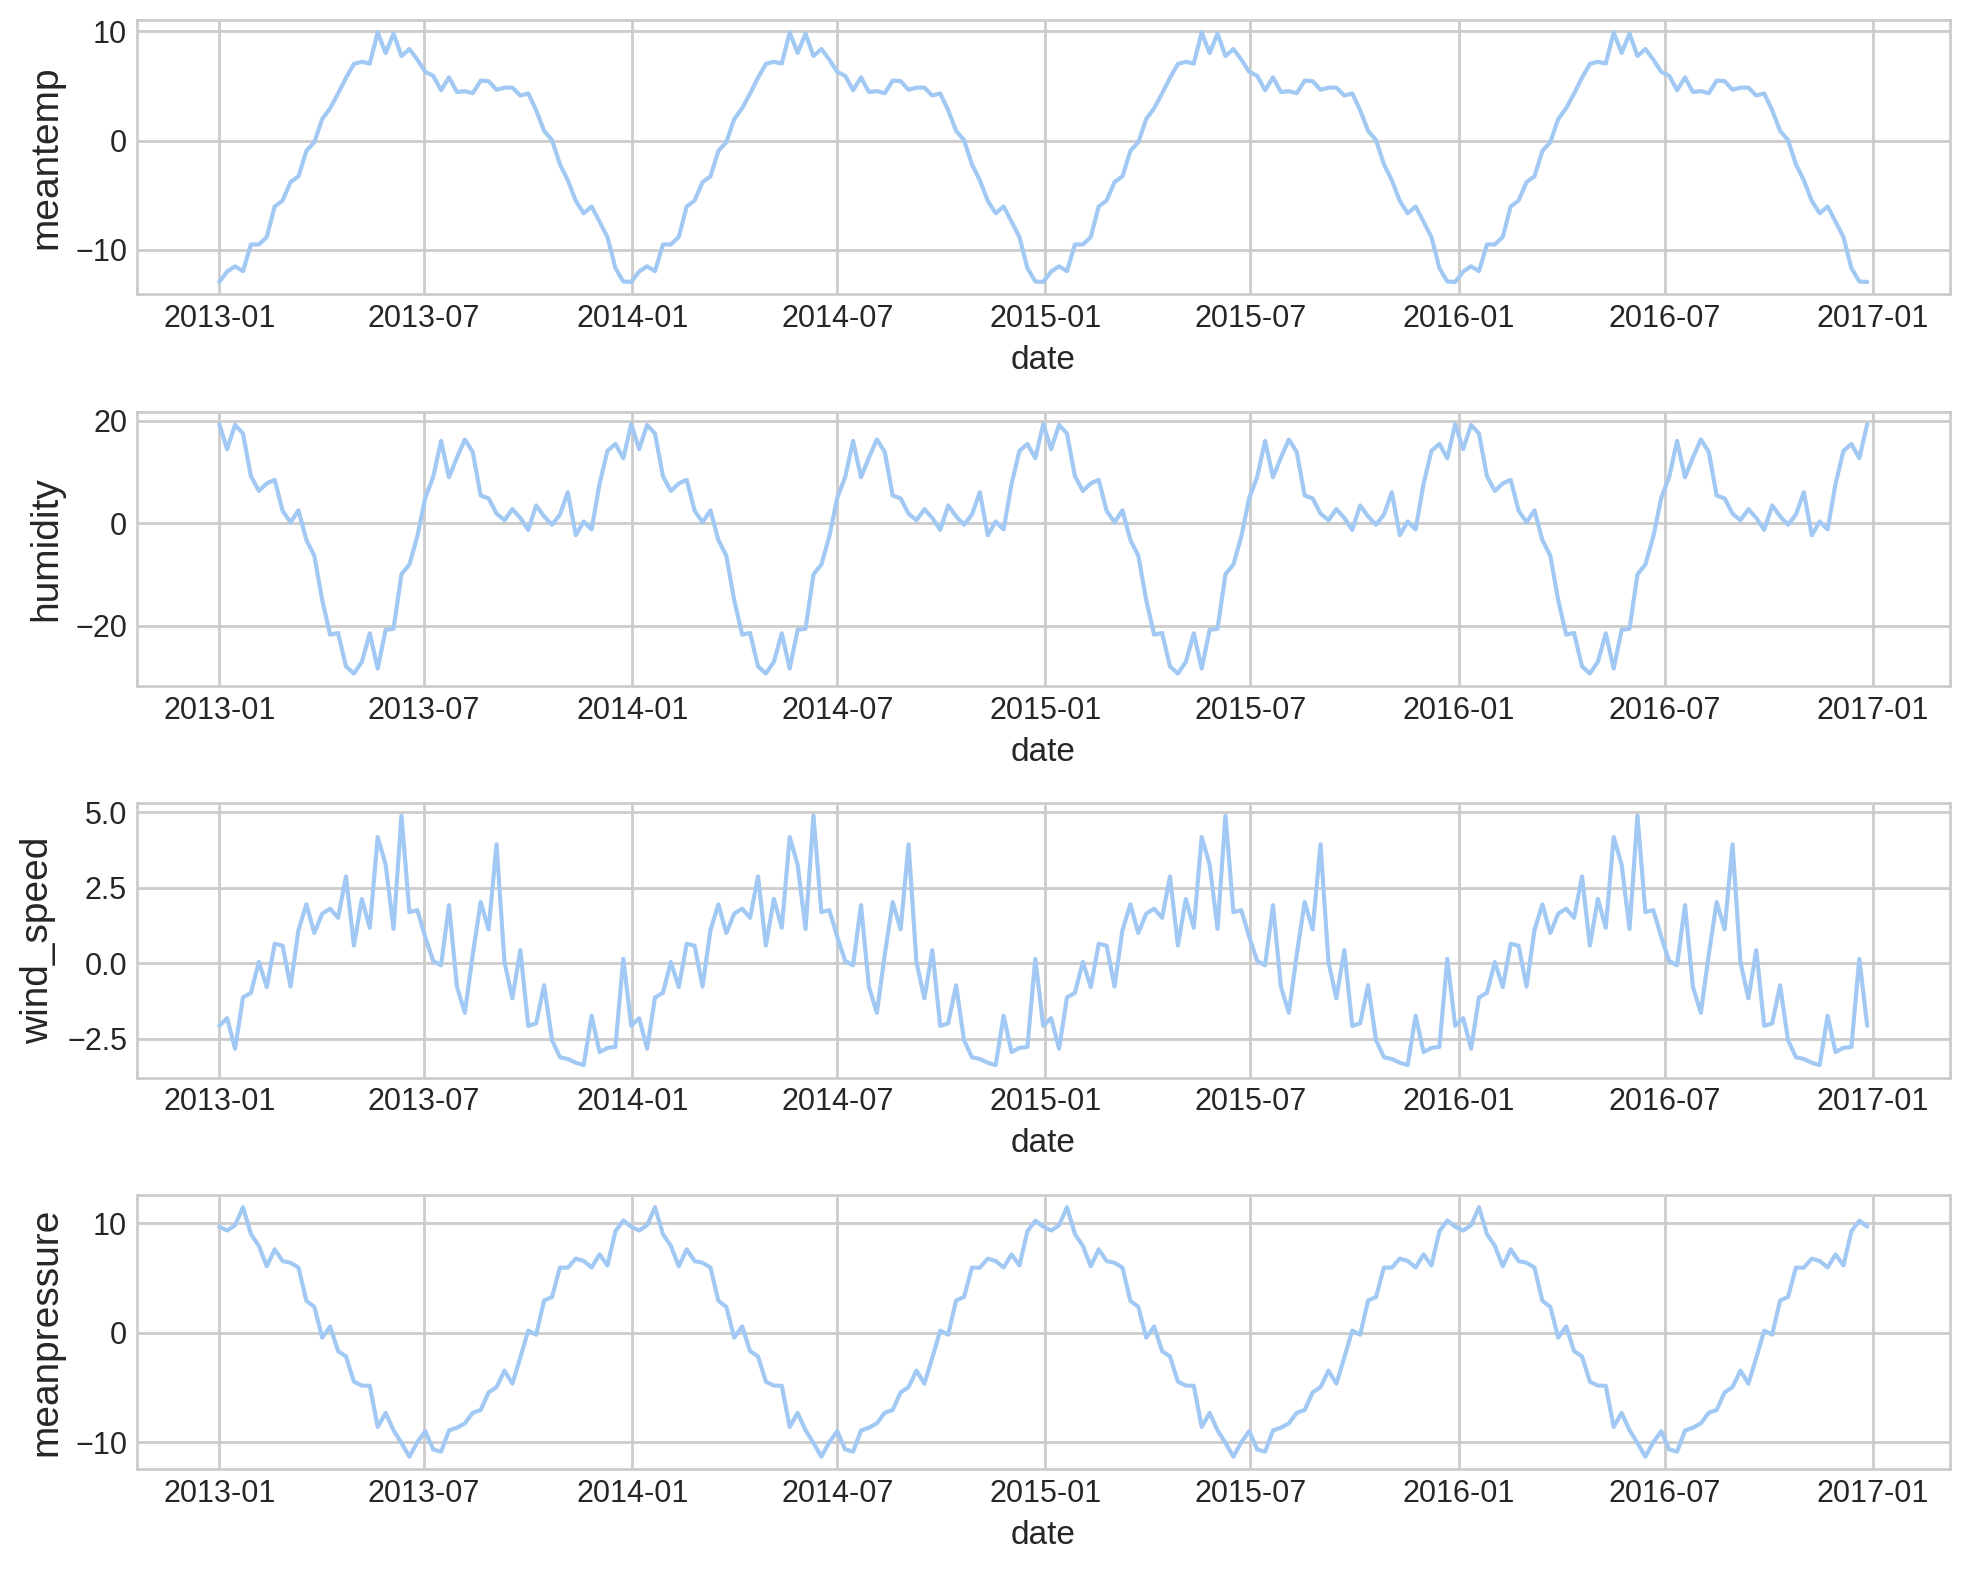

In [30]:
# Plotting only seasonality for each column
for column in columns:
    decomp = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

fig, ax =plt.subplots(nrows=4,ncols=1,figsize=(10,8))

for i, column in enumerate(columns):
    sns.lineplot(x=df['date'], y=df[column + '_seasonal'], ax=ax[i])
    ax[i].set_ylabel(ylabel=column, fontsize=14)

plt.tight_layout()

We can observe a negative correlation between humidity and pressure with increasing temperatures and wind speed. The weather patterns also appear to match the description provided in the 'What kind of climate does Delhi have?' section.

Lastly, let's plot a correlation heatmap to provide further evidence for the correlation observed earlier between humidity, pressure, temperature, and wind speed.

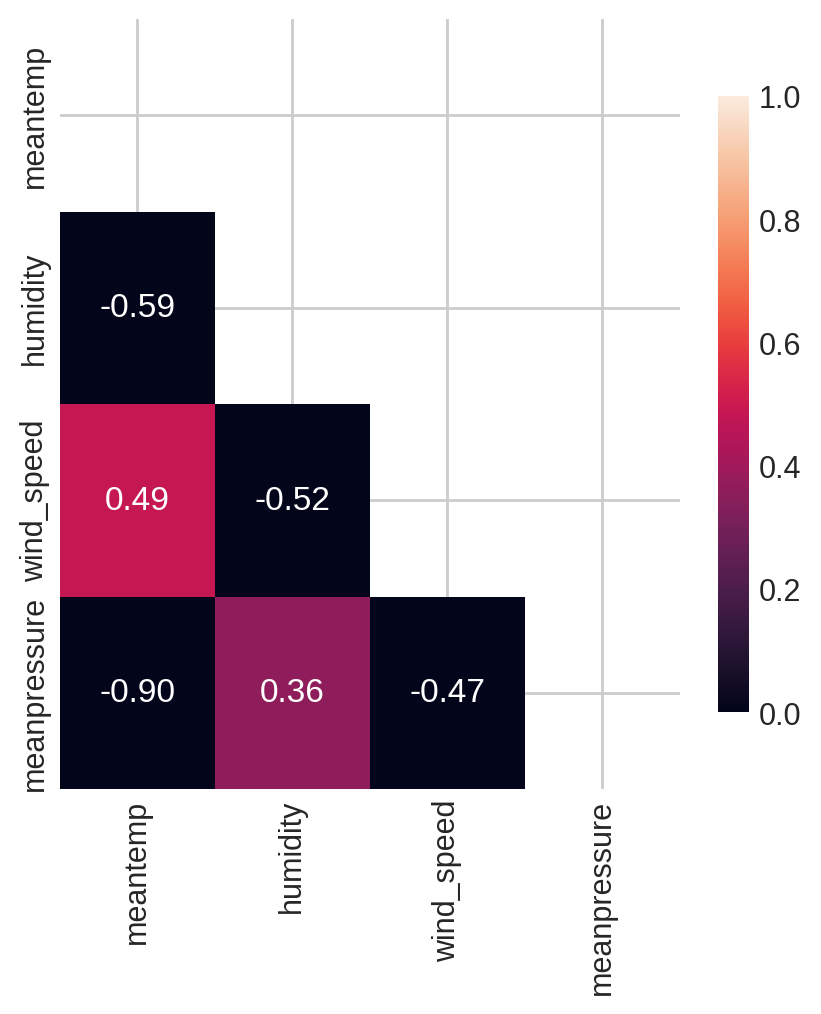

In [31]:
# Plotting correlation heatmap of the dataset
corr=df[columns].corr()
mask= np.triu(np.ones_like(corr,dtype=np.bool))
fig,ax= plt.subplots(figsize=(5,5))
sns.heatmap(corr,mask=mask, annot=True, fmt=".2f",cbar_kws={"shrink": .8}, vmin=0, vmax=1)
None

# Model building and evaluation

We will use the ARIMA model to perform univariate time series forecasts and the Prophet model for multivariate time series forecasts. **Our objective is to predict HUMIDTY for the next 32 weeks.**

Let's begin by defining the size of our training set.

In [32]:
# Defining training dataset size (85%)
train_size = int(0.85 * len(df))

In [33]:
# Defining univariate Dataframe - Target = humidity
univariate_df=df[['date', 'humidity']].copy()
univariate_df.columns = ['ds', 'y']

In [34]:
# Train - Validation split
train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

In [35]:
# Tunning ARIMA model with AutoArima
model = pm.auto_arima(y_train, start_p=0, start_q=0,
                      test='adf',
                      max_p=3, max_q=3,
                      m=1,
                      d=None,
                      seasonal=False,
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1967.723, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1290.991, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1773.679, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1283.688, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1285.465, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1285.565, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1640.820, Time=0.19 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1285.634, Time=0.27 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1274.339, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1380.066, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1276.393, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1275.003, Time=0.26 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1275.369, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : 

In [36]:
# Defining and fiting ARIMA model
model = ARIMA(y_train, order=(2,0,0),trend='c')
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  177
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -632.823
Date:                Sat, 14 Oct 2023   AIC                           1273.646
Time:                        14:55:58   BIC                           1286.350
Sample:                             0   HQIC                          1278.798
                                - 177                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         60.4300      4.365     13.844      0.000      51.874      68.986
ar.L1          0.6978      0.073      9.533      0.000       0.554       0.841
ar.L2          0.1650      0.070      2.342      0.0

In [37]:
# Prediction with ARIMA
y_pred = model_fit.forecast(32)

score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print('RMSE: {}'.format(score_rmse))

RMSE: 13.415552116744601


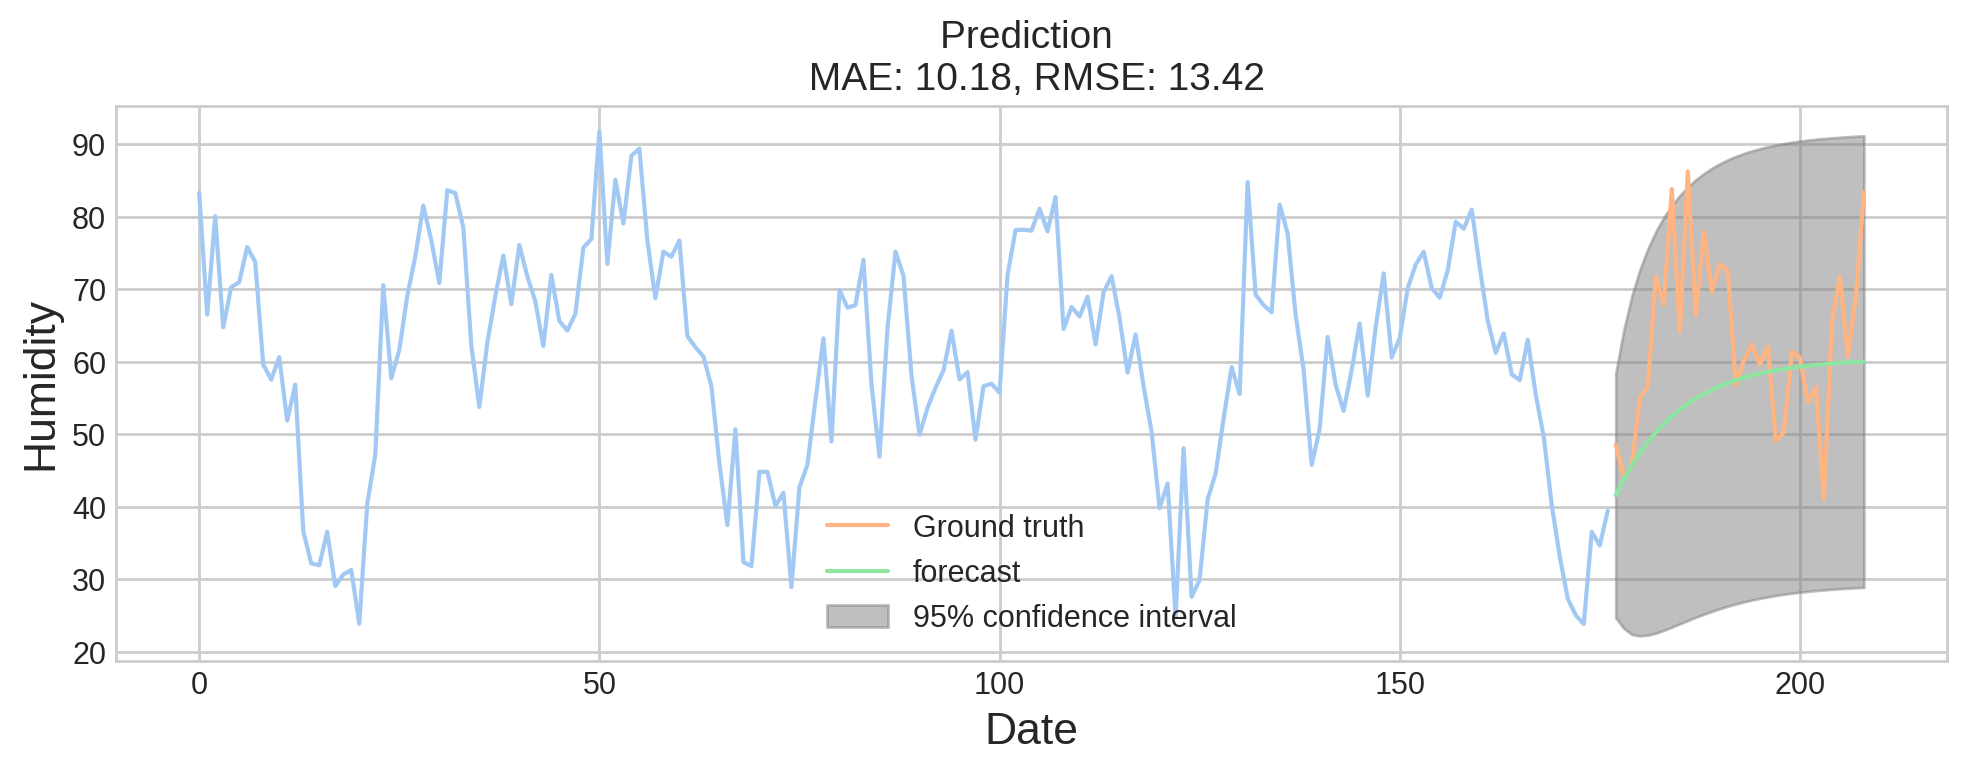

In [40]:
# Plotting forecast - ARIMA univariate analysis
fig, ax = plt.subplots(figsize=(10, 4))

sns.lineplot(x=x_train.index, y=y_train['y'], ax=ax)
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, label='Ground truth')
plot_predict(model_fit,177, 208, ax=ax)

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=16)
ax.set_ylabel(ylabel='Humidity', fontsize=16)

plt.tight_layout()

## Multivariate time series forecasts using Prophet

In [39]:
# Defining multivariate Dataframe - Target = humidity
features= ['meantemp',
          'wind_speed',
          'meanpressure']

target=['humidity']

multivariate_df= df[['date'] + target + features].copy()
multivariate_df.columns = ['ds', 'y'] + features

multivariate_df.head(5).append(multivariate_df.tail(5))

,ds,y,meantemp,wind_speed,meanpressure
0,2013-01-01,83.295238,7.604762,2.903810,1017.685714
1,2013-01-08,66.511905,13.176871,8.013265,1015.942177
2,2013-01-15,80.068027,13.409524,4.471905,1017.972789
3,2013-01-22,64.748299,12.848639,4.981973,1019.884694
4,2013-01-29,70.279592,16.107653,3.396378,1016.554592
204,2016-11-29,65.384536,19.883387,4.234881,1017.473212
205,2016-12-06,71.711197,18.500047,2.837198,1015.210392
206,2016-12-13,60.698526,17.578005,6.974330,1017.191007
207,2016-12-20,69.026283,17.020965,9.403279,1014.833210
208,2016-12-27,83.352881,14.742226,5.245749,1016.612457


In [41]:
# Train - Validation split
train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3,4]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

In [42]:
# Train the model
model = Prophet()
model.add_regressor('meantemp')
model.add_regressor('wind_speed')
model.add_regressor('meanpressure')

# Fit the model with train set
model.fit(train)

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

print('RMSE: {}'.format(score_rmse))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsbvpiwrz/23aj_ldw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsbvpiwrz/owbkont1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25748', 'data', 'file=/tmp/tmpsbvpiwrz/23aj_ldw.json', 'init=/tmp/tmpsbvpiwrz/owbkont1.json', 'output', 'file=/tmp/tmpsbvpiwrz/prophet_modelfngpk32c/prophet_model-20231014145733.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:57:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:57:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 6.214381392855684


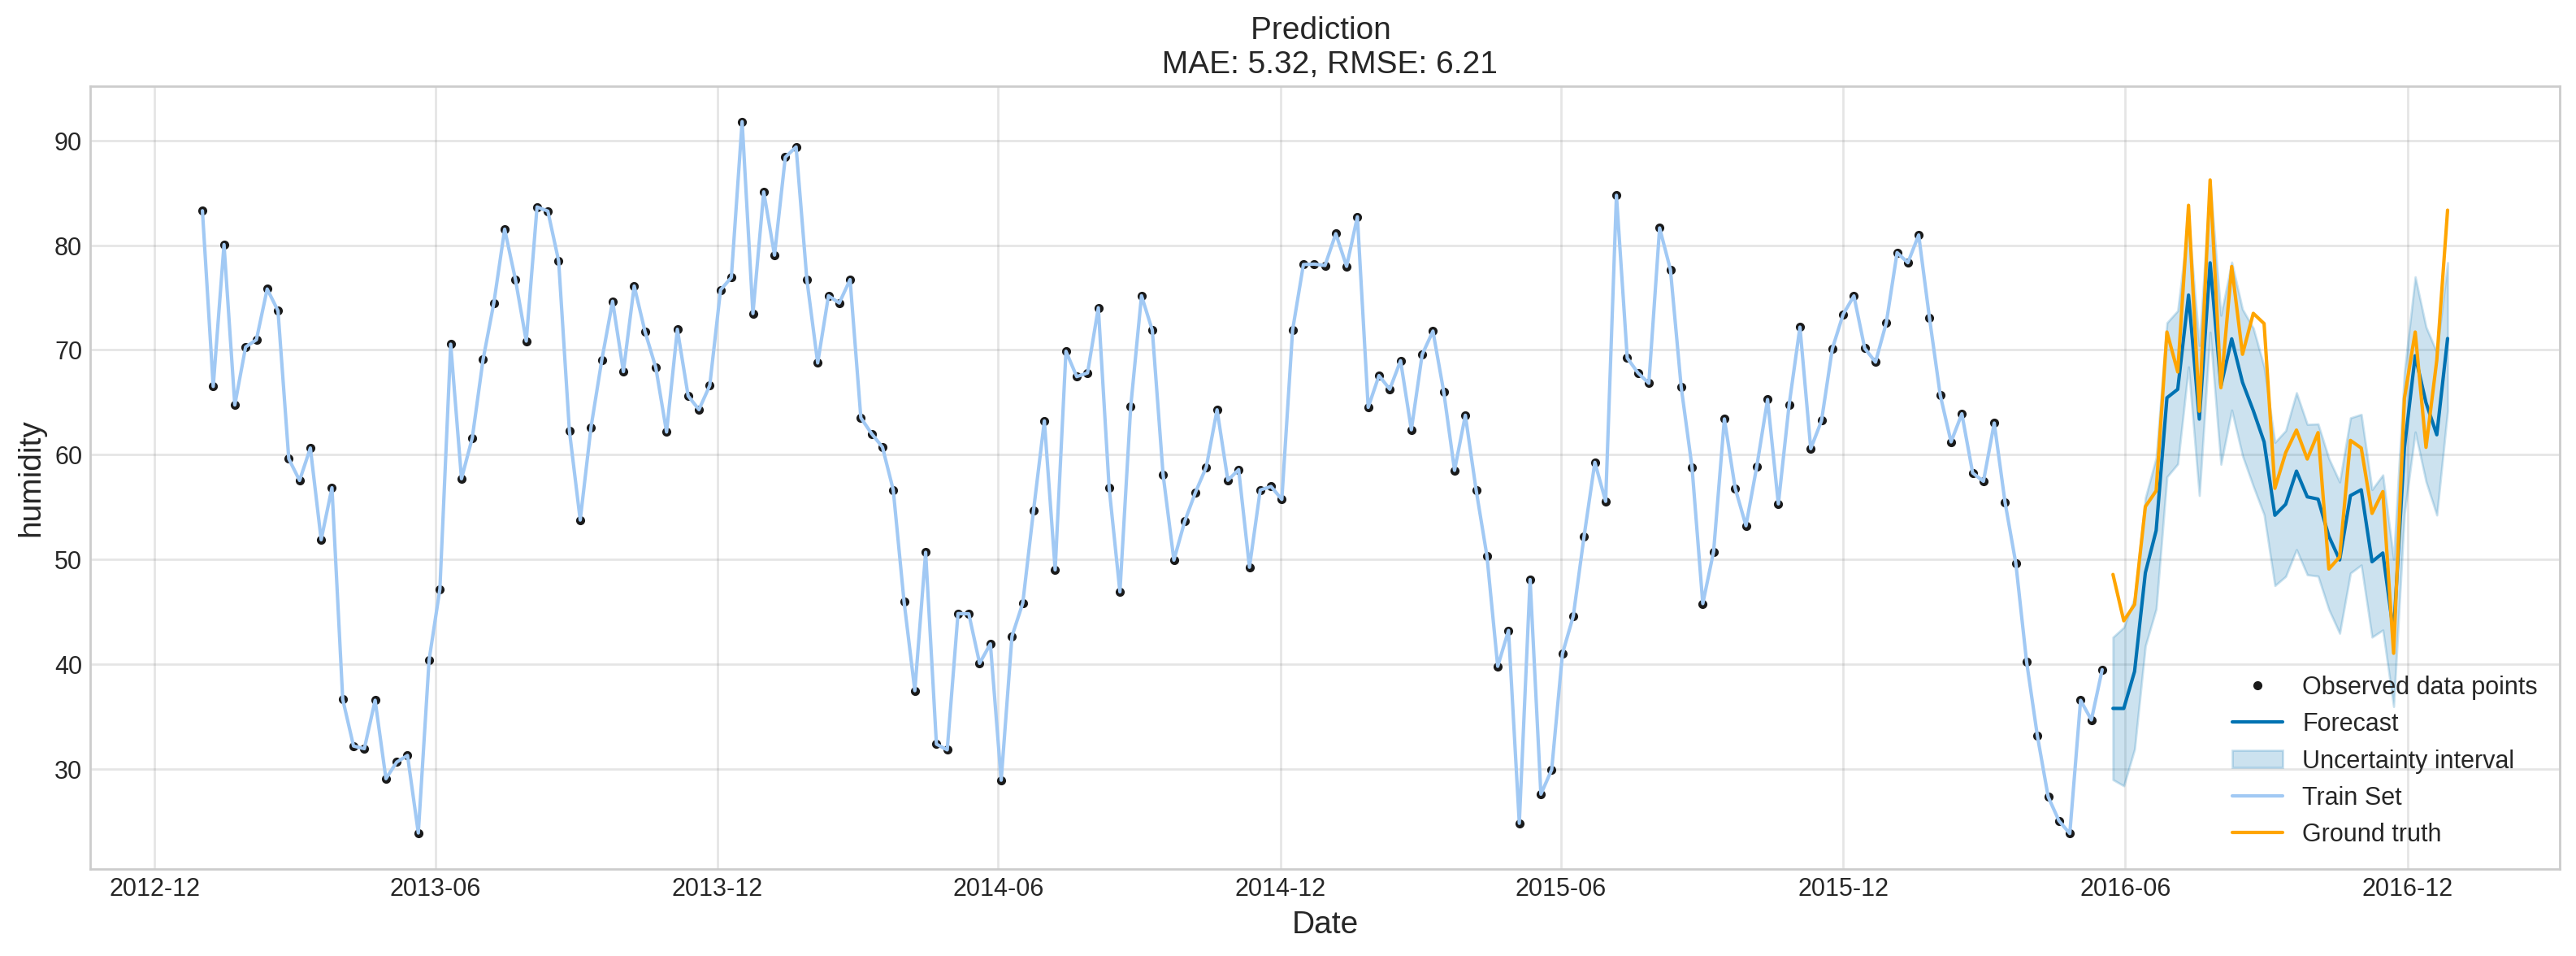

In [44]:
# Plotting forecast - Prophet multivariate analysis
fig, ax = plt.subplots(figsize=(16, 6))

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_train['ds'], y=y_train['y'], ax=ax, label='Train Set')
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='humidity', fontsize=14)

plt.tight_layout()